This follows the code here http://nbviewer.ipython.org/github/BVLC/caffe/blob/master/examples/filter_visualization.ipynb

The purpose is to visualise the network architectures and learn how to extract features on the go. At this point I have already downloaded the pretrained CaffeNet model.

I've also already downloaded and added a picture (different to theirs) of a tabby cat and added this to the directory. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

caffe_root = '/home/alex/Caffe/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# This just customizes a few aspects of the plots
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Check if the file can be found
import os
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Model not found")


Set caffe to CPU mode, load the net and configure input preprocessing

In [40]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Reshape the net to accept a single input then do a forward pass

In [21]:
net.blobs['data'].reshape(1,3,227,227)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Predicted class is #971.


This section here is used for my own sake to understand the pre-processing that has happened. It would appear that once the means are removed, when all three channels are combined I see complete noise! The only way to make sense of anything is to use a single channel at a time. 

(227, 227)


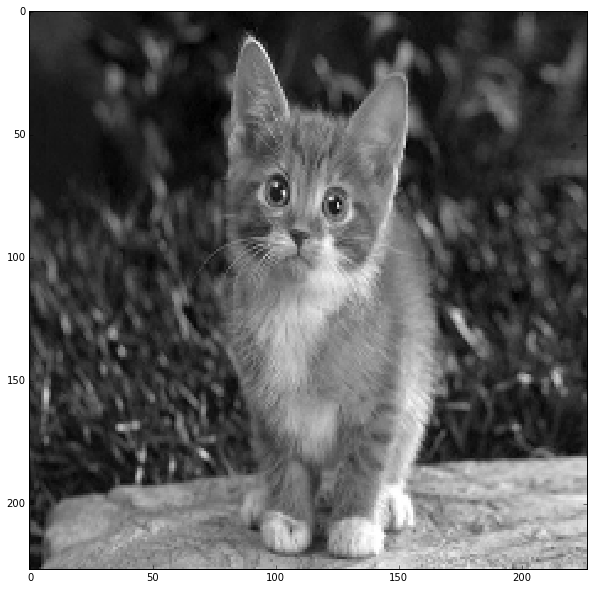

In [43]:
image = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
image = image[0,:,:]
print image.shape
plt.imshow(image)

In [24]:
np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)

array([ 104.00698793,  116.66876762,  122.67891434])

This code is then used to display the names and shapes of the network layers. 

In [6]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 227, 227)),
 ('conv1', (1, 96, 55, 55)),
 ('pool1', (1, 96, 27, 27)),
 ('norm1', (1, 96, 27, 27)),
 ('conv2', (1, 256, 27, 27)),
 ('pool2', (1, 256, 13, 13)),
 ('norm2', (1, 256, 13, 13)),
 ('conv3', (1, 384, 13, 13)),
 ('conv4', (1, 384, 13, 13)),
 ('conv5', (1, 256, 13, 13)),
 ('pool5', (1, 256, 6, 6)),
 ('fc6', (1, 4096)),
 ('fc7', (1, 4096)),
 ('fc8', (1, 1000)),
 ('prob', (1, 1000))]

**Helper functions for visualisation**

In [12]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    print data.shape
    plt.imshow(data)

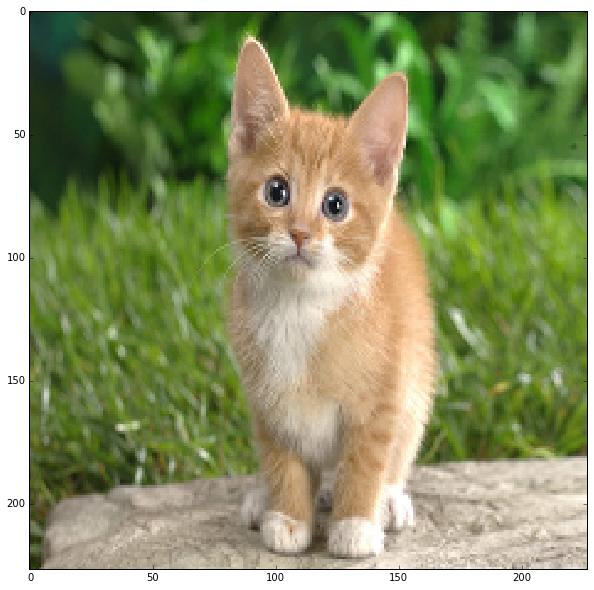

In [8]:
plt.imshow(transformer.deprocess('data',net.blobs['data'].data[0]))

Display the first layer of filters, conv1

(96, 3, 11, 11)
(120, 120, 3)


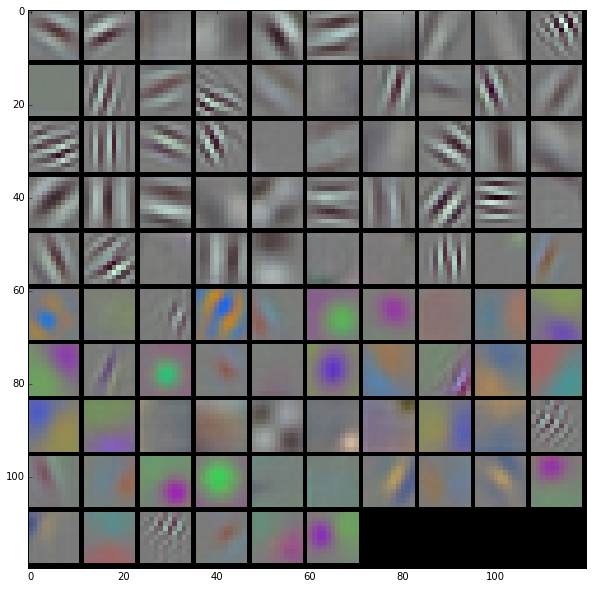

In [13]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
print filters.shape
vis_square(filters.transpose(0, 2, 3, 1))

The output of each of the first layes

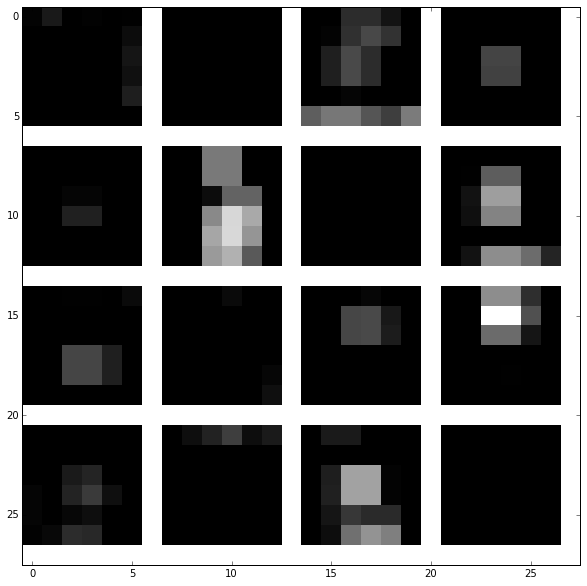

In [16]:
feat = net.blobs['pool5'].data[0, :16]
vis_square(feat, padval=1)

A slightly different approach to plotting the fully connected layers

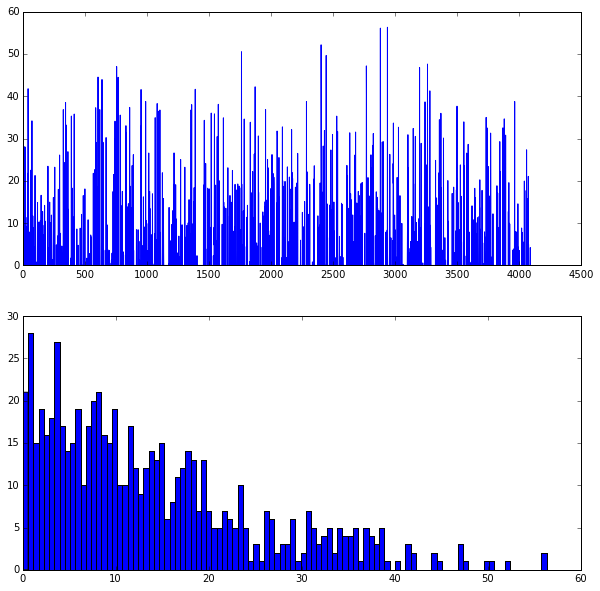

In [18]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The output probabilities

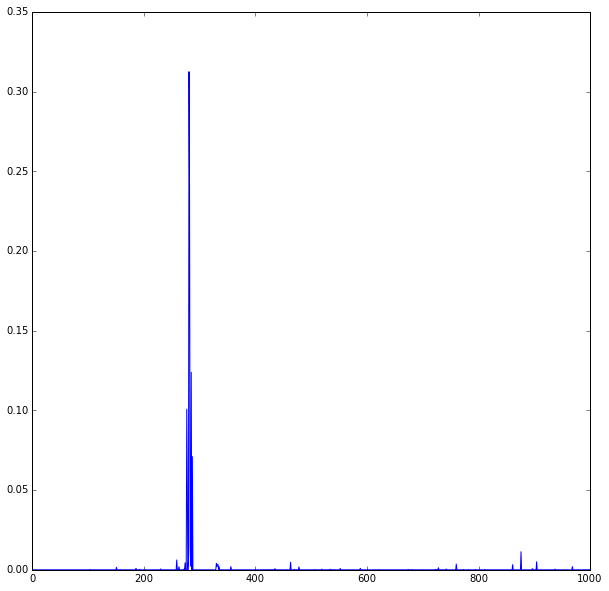

In [19]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat);

In [20]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']
